In [104]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
import pickle


# Load the dataset
file_path = './data/dementia_data-MRI-features.csv'
data = pd.read_csv(file_path)

# Drop unnecessary identifier columns
data_cleaned = data.drop(columns=["Subject ID", "MRI ID","Hand"])

# Drop rows with missing values
data_cleaned.dropna(inplace=True)
# data_cleaned['Group_v'] = data_cleaned['Group']
data_cleaned['Group'] = data_cleaned['Group'].map({ 'Converted':0,'Nondemented': 2, 'Demented': 1})
print(data_cleaned.head())

# Encode categorical variables
label_encoders = {}
categorical_columns = [ "M/F"]
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))
    label_encoders[col] = le

# Discretize continuous variables into limited categories (e.g., 4 bins)
continuous_columns = ["MR Delay", "Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_cleaned[continuous_columns] = discretizer.fit_transform(data_cleaned[continuous_columns])

for col in continuous_columns:
    data_cleaned[col] = data_cleaned[col].astype(int)
    
    
data_cleaned['SES'] = data_cleaned['SES'].astype(int)
data_cleaned['MR_Delay'] = data_cleaned['MR Delay']
data_cleaned = data_cleaned.drop(columns=['MR Delay'])
# data_cleaned.drop(columns=["MR_delay"], inplace=True)

# Display the first few rows to verify encoding

# Display the cleaned data's structure and the first few rows to verify
print(data_cleaned.info())
print(data_cleaned.head())

# print('Group------------>',data_cleaned['Group'],'Group_v--------------------------->',data_cleaned['Group_v'])

# Save the fitted discretizer to a file
with open('./config/discretizer.pkl', 'wb') as f:
    pickle.dump(discretizer, f)



   Group  Visit  MR Delay M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0      2      1         0   M   87    14  2.0  27.0  0.0  1987  0.696  0.883
1      2      2       457   M   88    14  2.0  30.0  0.0  2004  0.681  0.876
5      2      1         0   F   88    18  3.0  28.0  0.0  1215  0.710  1.444
6      2      2       538   F   90    18  3.0  27.0  0.0  1200  0.718  1.462
7      2      1         0   M   80    12  4.0  28.0  0.0  1689  0.712  1.039
<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 0 to 372
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Group     354 non-null    int64
 1   Visit     354 non-null    int64
 2   M/F       354 non-null    int32
 3   Age       354 non-null    int32
 4   EDUC      354 non-null    int32
 5   SES       354 non-null    int32
 6   MMSE      354 non-null    int32
 7   CDR       354 non-null    int32
 8   eTIV      354 non-null    int32
 9   nWBV      354 non-null    

c:\Users\rohit\anaconda3\envs\AML\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [105]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


# Define features and target variable
X = data_cleaned.drop(columns=['Group'])
y = data_cleaned['Group']

#save cleaned data into file
data_cleaned.to_csv('./data/discrete_dementia_data.csv', index=False)


# Perform 80:20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of classes in the resampled training set
print("Resampled Training set class distribution:")
print(y_train_resampled.value_counts(normalize=True))


# Combine features and target for saving
train_data = pd.concat([X_train_resampled, y_train_resampled], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save to CSV files
train_data.to_csv('./data/dementia_data_train.csv', index=False)
test_data.to_csv('./data/dementia_data_test.csv', index=False)

print("Train and test datasets saved as 'dementia_data_train.csv' and 'dementia_data_test.csv'")


Resampled Training set class distribution:
Group
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64
Train and test datasets saved as 'dementia_data_train.csv' and 'dementia_data_test.csv'


In [67]:
# Check class distribution in the full dataset
print("Full dataset class distribution:")
print(y.value_counts(normalize=True))

# Check class distribution in the training set
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

# Check class distribution in the testing set
print("Testing set class distribution:")
print(y_test.value_counts(normalize=True))


Full dataset class distribution:
Group
2    0.536723
1    0.358757
0    0.104520
Name: proportion, dtype: float64
Training set class distribution:
Group
2    0.534413
1    0.360324
0    0.105263
Name: proportion, dtype: float64
Testing set class distribution:
Group
2    0.542056
1    0.355140
0    0.102804
Name: proportion, dtype: float64


In [10]:
import pandas as pd
from sklearn.model_selection import KFold
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, K2Score, HillClimbSearch
from pgmpy.factors.continuous import GaussianDistribution
import numpy as np

# Load the dataset
data = pd.read_csv("dementia_data.csv")  # Replace with your file path

# Encode categorical columns if not already encoded
categorical_columns = ['Group', 'M/F', 'Hand']  # Example of columns to encode
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up model structure (example)
# Define the structure manually or use HillClimbSearch
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=K2Score(data))

# Gaussian Bayesian Network with k-fold cross-validation
for train_index, test_index in kf.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Define the Bayesian model
    model = BayesianNetwork(best_model.edges())

    # Train the model with Maximum Likelihood Estimation (MLE)
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)

    # Testing and evaluation can be done here for each fold
    # Example: predicting or calculating log-likelihood
    # log_likelihood = model.score(test_data)
    # print(f"Log-likelihood for fold: {log_likelihood}")

print("Training complete with 5-fold cross-validation")


ImportError: cannot import name 'GaussianDistribution' from 'pgmpy.factors.continuous' (c:\Users\rohit\anaconda3\envs\AML\lib\site-packages\pgmpy\factors\continuous\__init__.py)

In [25]:


# Query with continuous values
query_continuous = {
    "Visit": 2, "Age": 88, "EDUC": 14, "SES": 2, 'MR Delay':2,
    "MMSE": 30, "CDR": 0, "eTIV": 2004, "nWBV": 0.681, "ASF": 0.876
}

# Continuous columns to discretize
# continuous_columns = ["Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]
continuous_columns = ["MR Delay", "Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]


# Transform continuous query values to discrete bins
query_discrete = query_continuous.copy()
for col in continuous_columns:
    # Use the same discretizer to transform the single value
    # Note: KBinsDiscretizer expects a 2D array, hence [[value]]
    query_value = [[query_continuous[col]]]  # Shape (1, 1)
    print(query_value)
    # Use the discretizer to transform the value
    query_discrete[col] = int(discretizer.transform(query_value)[0, 0])

print(query_discrete)

# # Perform the probabilistic query with the discrete values
# # For instance, in pgmpy you might use `inference.query`
# # Assuming you have an `inference` object from VariableElimination or similar in pgmpy
# from pgmpy.inference import VariableElimination

# inference = VariableElimination(model)
# result = inference.query(
#     variables=["Group"],
#     evidence=query_discrete
# )

# print("Query Result:", result)


[[2]]


c:\Users\rohit\anaconda3\envs\AML\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but KBinsDiscretizer is expecting 8 features as input.

In [74]:
import pickle
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

query = "P(Group | Visit=3, Age=80,EDUC=12, MMSE=22, CDR=0.5, eTIV=1698, nWBV=0.701,ASF= 1.034)"

def continuous_to_discrete_query(query):
    continuous_columns = ["MR Delay", "Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]
    discretizer_file_path = './config/discretizer.pkl'
    
    # Load the fitted discretizer from the file
    with open(discretizer_file_path, 'rb') as f:
        discretizer = pickle.load(f)

    return make_query_discrete(query, continuous_columns, discretizer)

def make_query_discrete(query, continuous_columns, discretizer):
    query = query.replace(" ", "")
    target = query.split("|")[0].replace("P(", "")
    evedences = query.split("|")[1].replace(")", "").split(",")

    query_continuous = {}
    for ev in evedences:
        key, value = ev.split("=")
        query_continuous[key] = value

    # Create a DataFrame with a single row for the discretizer
    query_df = pd.DataFrame([query_continuous], columns=continuous_columns).fillna(0)

    # Transform the continuous query values to discrete bins
    transformed = discretizer.transform(query_df)  # Shape (1, n_features)

    # Create a new dictionary to hold discrete values
    query_discrete = query_continuous.copy()
    for i, col in enumerate(continuous_columns):
        if col in query_discrete:
            query_discrete[col] = int(transformed[0, i])

    ev = [f'{key}={query_discrete[key]}' for key in query_discrete]
    print(f'P({target}|{",".join(ev)})')
    
    return f'P({target}|{",".join(ev)})'

continuous_to_discrete_query(query)


P(Group|Visit=3,Age=2,EDUC=1,MMSE=2,CDR=1,eTIV=2,nWBV=1,ASF=0)


'P(Group|Visit=3,Age=2,EDUC=1,MMSE=2,CDR=1,eTIV=2,nWBV=1,ASF=0)'

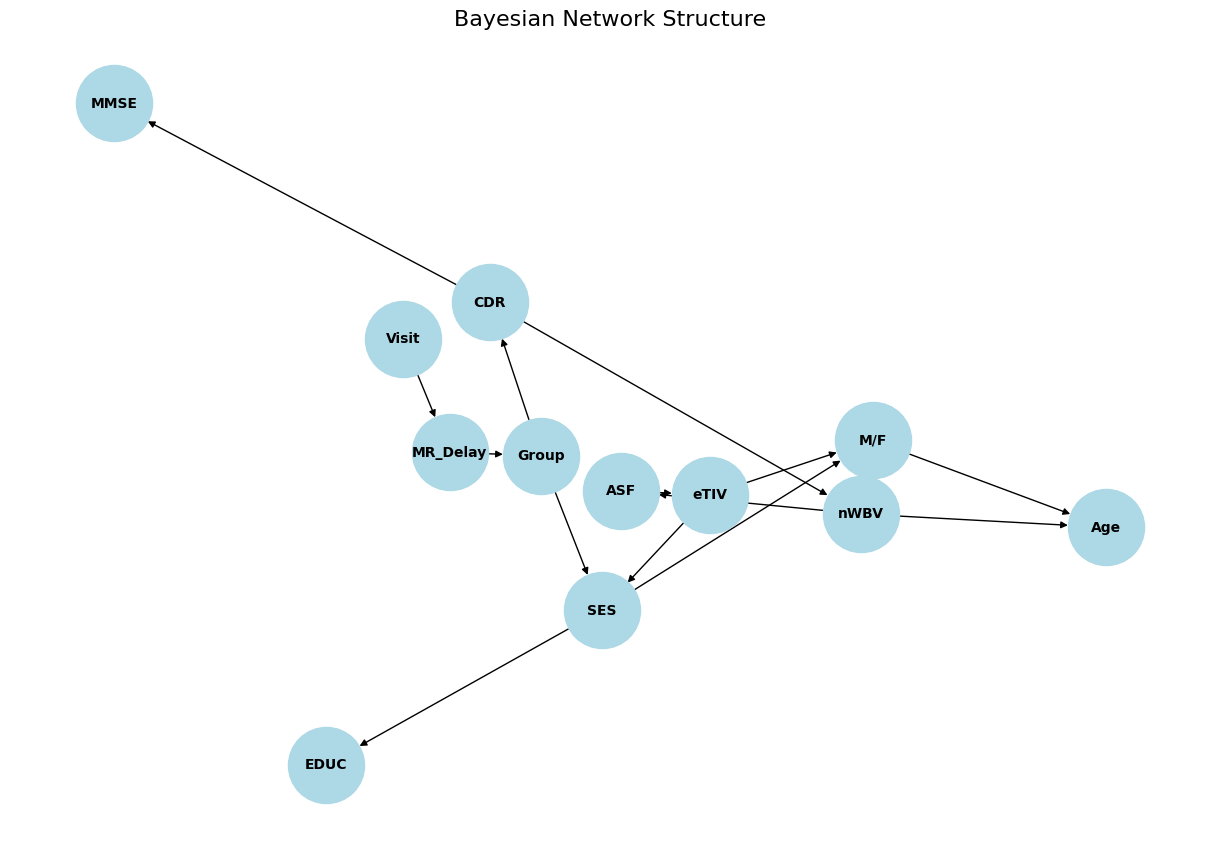

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define the edges based on the provided relationships
edges = [
    ('Group', 'CDR'),
    ('Group', 'SES'),
    ('Visit', 'MR_Delay'),
    ('MR_Delay', 'Group'),
    ('M/F', 'Age'),
    ('SES', 'EDUC'),
    ('SES', 'M/F'),
    ('CDR', 'MMSE'),
    ('CDR', 'nWBV'),
    ('eTIV', 'M/F'),
    ('eTIV', 'SES'),
    ('nWBV', 'Age'),
    ('nWBV', 'ASF'),
    ('ASF', 'eTIV')
]

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True, arrowstyle='-|>')
plt.title("Bayesian Network Structure", fontsize=16)
plt.show()

"P(Group|Visit=3,Age=2,EDUC=1,MMSE=2,CDR=1,eTIV=2,nWBV=1,ASF=0"
"P(Group|Visit=2,Age=1,EDUC=1,SES=2,MMSE=3,CDR=0,eTIV=3,nWBV=0,ASF=0)"


In [9]:
COMPUTING performance on test data...
Balanced Accuracy=0.7070065445746027
F1 Score=0.8687423451654547
Area Under Curve=0.4664378337147216
Brier Score=0.013880668852643482
KL Divergence=99.79329425545026
Training Time=this number should come from the CPT_Generator!
Inference Time=0.09596109390258789 secs.

Model -> 
structure:P(Visit);P(MR_Delay|Visit);P(Group|MR_Delay);P(CDR|Group);P(MMSE|CDR);P(nWBV|CDR);P(ASF|nWBV);P(Age|nWBV,M/F);P(eTIV|ASF);P(M/F|eTIV,SES);P(SES|EDUC);P(EDUC|eTIV,Group)


COMPUTING performance on test data...
Balanced Accuracy=0.7272727272727272
F1 Score=0.8886833494723215
Area Under Curve=0.46491228070175433
Brier Score=0.010097246474140025
KL Divergence=98.62747800959588
Training Time=this number should come from the CPT_Generator!
Inference Time=0.102325439453125 secs.


COMPUTING performance on test data...
Balanced Accuracy=0.95
F1 Score=0.953023019340545
Area Under Curve=0.9715789473684211
Brier Score=0.2507101004634838
KL Divergence=14.168921981535366
Training Time=this number should come from the CPT_Generator!
Inference Time=0.10036468505859375 secs.

SyntaxError: invalid syntax (3972570455.py, line 1)

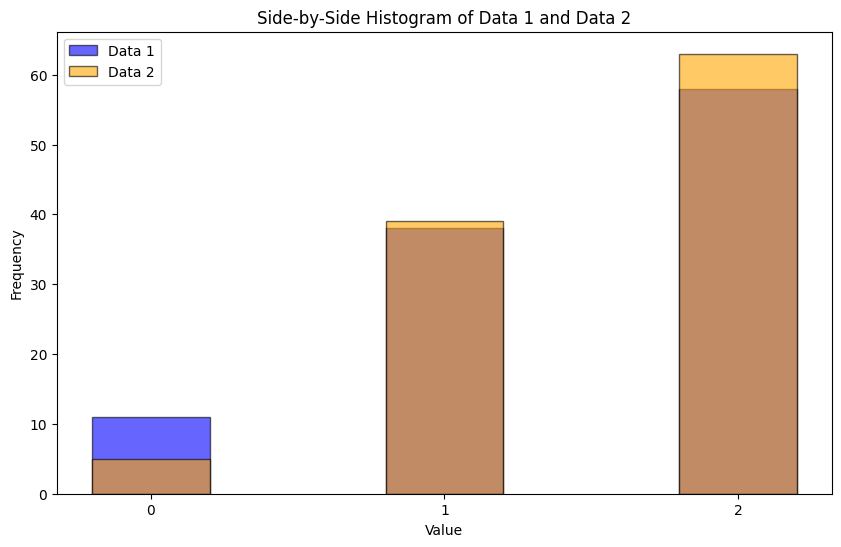

In [58]:
import matplotlib.pyplot as plt

# Data
data1 = [1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 
         2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 
         1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 
         1, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 
         1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1]
data2 = [1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 
         2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 
         1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 
         1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 
         1, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1]

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(data1, bins=[0, 1, 2, 3], edgecolor='black', align='left', rwidth=0.4, label="Data 1", color='blue', alpha=0.6)
plt.hist(data2, bins=[0, 1, 2, 3], edgecolor='black', align='left', rwidth=0.4, label="Data 2", color='orange', alpha=0.6)

# Labeling
plt.xticks([0, 1, 2])
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Side-by-Side Histogram of Data 1 and Data 2")
plt.legend()

plt.show()


In [59]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Ground truth and predictions
Y_true = [1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 
          2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 
          1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 
          1, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 
          1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1]

Y_prob = [0.9962598199975182, 0.9743738690083193, 0.992684388582693, 0.7565328605888396, 0.9906154310497827, 
          0.9916897778202836, 0.9753381884152057, 0.18108373960158297, 0.9371020521938085, 0.8172873961037203, 
          0.6652793931113513, 0.9867798855010383, 0.9014646462719007, 0.85821400157766, 0.9750268217524632, 
          0.9666362222175585, 0.9896853350989585, 0.9473763527001476, 0.9899038703954912, 0.8953474042182066, 
          0.890621712094065, 0.9676959099830867, 0.9691662539401538, 0.9614182257894318, 0.9524323016609413, 
          0.5321453939545466, 0.5107723392991436, 0.89366541560749, 0.9758209879890276, 0.9996987318135901, 
          0.9585298516859041, 0.9723901032971002, 0.9998715922638235, 0.9967407282495099, 0.9997668128524544, 
          0.984009195612114, 0.948890721989006, 0.9871779092484755, 0.9331685165268537, 0.7948648212560112, 
          0.9774840468187133, 0.8885429564619552, 0.7661093389890649, 0.9329843845907695, 0.7176894066662481, 
          0.9820239634021523, 0.9022565535789038, 0.8252562645773428, 0.9071512495631361, 0.9769760599559744, 
          0.7653243331812172, 0.6511782445768378, 0.7151773130385338, 0.9962874086447525, 0.9321314315563827, 
          0.8133851201933091, 0.990872047078806, 0.8757047699561945, 0.8909695764841207, 0.919609783346365, 
          0.9099174476755569, 0.9358740781294698, 0.9583044131524623, 0.9738231466913626, 0.6589469402388433, 
          0.9861719488186033, 0.7426117578169404, 0.9922615111674553, 0.6712379691904601, 0.9533150527663942, 
          0.9975291270320359, 0.9424019182727988, 0.9993935036620413, 0.9633277196899632, 0.9803368243375562, 
          0.41595625323385876, 0.5795960957376405, 0.8409507917639985, 0.971318362858906, 0.9816966523778162, 
          0.9959123843480118, 0.9736850957650526, 0.8717757908490616, 0.9291445393947988, 0.8863662175646968, 
          0.762858553835607, 0.973686303252637, 0.98085203615549, 0.9034383233400777, 0.9790718334039221, 
          0.9797272804718148, 0.9702499514692483, 0.9171995968161074, 0.3512185171548708, 0.7555023041782001, 
          0.9597321852266674, 0.8021814212438095, 0.9475307939588354, 0.8043592682354543, 0.37921812198157734, 
          0.27791870364840826, 0.9626439188338239, 0.9665277415635528, 0.9569334921022936, 0.9226177172009167, 
          0.901078604361788, 0.9978869316783254]

# Reshape probabilities for each class
Y_prob = np.array(Y_prob).reshape(-1, 1)  # Reshape into a 2D array
Y_prob = np.hstack((1 - Y_prob, Y_prob * 0.5, Y_prob))

# Binarize the true labels
Y_true_binarized = label_binarize(Y_true, classes=[0, 1, 2])

# Calculate AUC for each class and average macro
auc = roc_auc_score(Y_true_binarized, Y_prob, average="macro", multi_class="ovr")
print("Multiclass AUC (macro-averaged):", auc)


Multiclass AUC (macro-averaged): 0.5675392690905141


In [ ]:


# Query with continuous values
query_continuous = {
    "Visit": 2, "Age": 88, "EDUC": 14, "SES": 2, 'MR Delay':2,
    "MMSE": 30, "CDR": 0, "eTIV": 2004, "nWBV": 0.681, "ASF": 0.876
}

# Continuous columns to discretize
# continuous_columns = ["Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]
continuous_columns = ["MR Delay", "Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV", "ASF"]


# Transform continuous query values to discrete bins
query_discrete = query_continuous.copy()
for col in continuous_columns:
    # Use the same discretizer to transform the single value
    # Note: KBinsDiscretizer expects a 2D array, hence [[value]]
    query_value = [[query_continuous[col]]]  # Shape (1, 1)
    print(query_value)
    # Use the discretizer to transform the value
    query_discrete[col] = int(discretizer.transform(query_value)[0, 0])

print(query_discrete)

# # Perform the probabilistic query with the discrete values
# # For instance, in pgmpy you might use `inference.query`
# # Assuming you have an `inference` object from VariableElimination or similar in pgmpy
# from pgmpy.inference import VariableElimination

# inference = VariableElimination(model)
# result = inference.query(
#     variables=["Group"],
#     evidence=query_discrete
# )

# print("Query Result:", result)


[[2]]


c:\Users\rohit\anaconda3\envs\AML\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but KBinsDiscretizer is expecting 8 features as input.